In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from copy import deepcopy

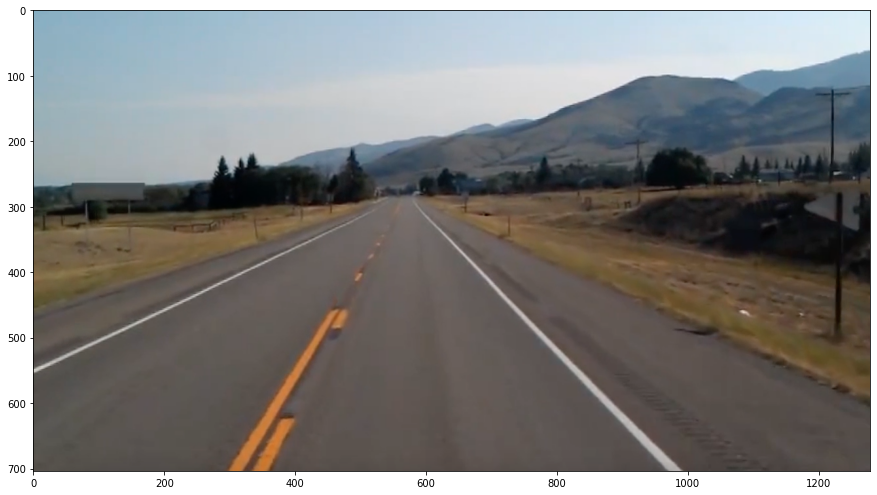

In [2]:
img_BGR = cv2.imread("./testHough.jpg")
img_RGB = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(15, 15))
plt.imshow(img_RGB)

In [3]:
# Noise Reduction Using Median Filter
blurred = cv2.medianBlur(img_BGR, 5)

# canny filter producers :
# step 1 : remove the noise in the image with a 5x5 Gaussian filter
# step 2 : Smoothened image is then filtered with a Sobel kernel in both horizontal and vertical direction to get first derivative in horizontal direction ( Gx) and vertical direction ( Gy). From these two images, we can find edge gradient and direction for each pixel
# step 3 :  Non-maximum Suppression - > After getting gradient magnitude and direction, a full scan of image is done to remove any unwanted pixels which may not constitute the edge. For this, at every pixel, pixel is checked if it is a local maximum in its neighborhood in the direction of gradient
# step 4 : Hysteresis Thresholding -> This stage decides which are all edges are really edges and which are not. For this, we need two threshold values, minVal and maxVal. Any edges with intensity gradient more than maxVal are sure to be edges and those below minVal are sure to be non-edges, so discarded. Those who lie between these two thresholds are classified edges or non-edges based on their connectivity. If they are connected to "sure-edge" pixels, they are considered to be part of edges. Otherwise, they are also discarded
# OpenCV puts all the above in single function, cv.Canny()
canny = cv2.Canny(blurred, 100, 150)

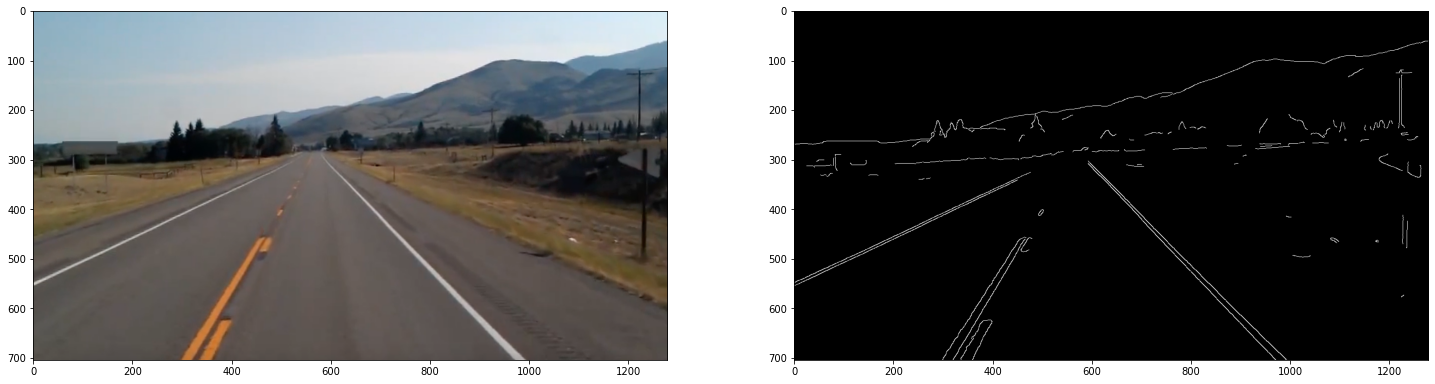

In [4]:
_, ax = plt.subplots(nrows=1, ncols=2, figsize=(25, 25))
ax = ax.flatten()
ax[0].imshow(img_RGB)
ax[1].imshow(canny, cmap="gray")

In [5]:
points = np.array([[[0, 700], [0, 500], [480, 300], [650, 300], [1000, 700]]])
mask = np.zeros(canny.shape[0:2], dtype=np.uint8)
cv2.fillPoly(mask, points, 255)

lane_edges = deepcopy(canny)
lane_edges[mask == 0] = 0

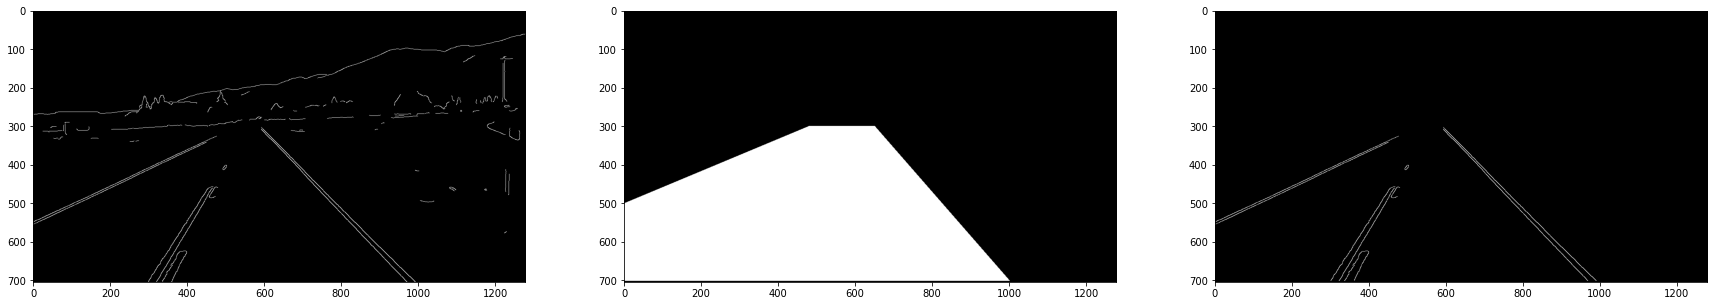

In [6]:
_, ax = plt.subplots(nrows=1, ncols=3, figsize=(30, 30))
ax = ax.flatten()
ax[0].imshow(canny, cmap="gray")
ax[1].imshow(mask, cmap="gray")
ax[2].imshow(lane_edges, cmap="gray")

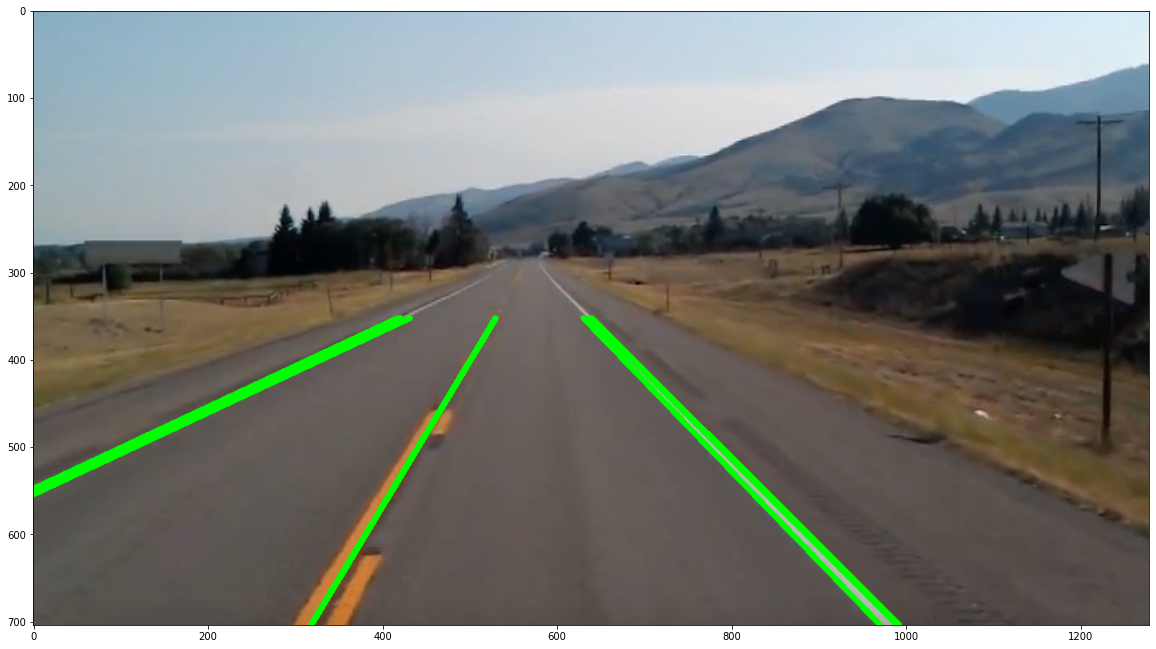

In [7]:
output_cv = deepcopy(img_RGB)
lines = cv2.HoughLinesP(lane_edges, rho=1, theta=np.pi / 180, threshold=200, minLineLength=50, maxLineGap=5)

# Draw the lines
if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line.reshape(4)
        parameters = np.polyfit((x1, x2), (y1, y2), 1)
        slope = parameters[0]
        intercept = parameters[1]

        y1 = output_cv.shape[0]
        y2 = int(y1/2)
        x1 = int((y1 - intercept) / slope)
        x2 = int((y2 - intercept) / slope)

        cv2.line(output_cv, (x1, y1), (x2, y2), (0, 255, 0), 6)

    plt.figure(figsize=(20, 20))
    plt.imshow(output_cv)

In [8]:
output = deepcopy(img_RGB)

height, width = lane_edges.shape
img_diagonal = np.ceil(np.sqrt(height ** 2 + width ** 2))

# rho max is equal to the img diagonal
rhos = np.arange(0, img_diagonal, 1)
thetas = np.deg2rad(np.arange(0.0, 360.0))

# create the empty Hough Accumulator with dimensions equal to the size of rhos and thetas
H = np.zeros((len(rhos), len(thetas)), dtype=np.uint64)

y_idx, x_idx = np.nonzero(lane_edges)  # find all edge (nonzero) pixel indexes
for i in range(len(x_idx)):  # cycle through edge points
    x = x_idx[i]
    y = y_idx[i]

    for j in range(len(thetas)):  # cycle through thetas and calc rho
        a = np.cos(thetas[j])
        b = np.sin(thetas[j])
        rho = int(round(x * a + y * b))
        H[rho, j] += 1


In [9]:
# find peaks
threshold = 200

from scipy.signal import argrelextrema
#indices = argrelextrema(H,np.greater)

from scipy.signal import find_peaks

indices, _ = find_peaks(H.flatten(), height=threshold, distance=10000)
peaks_indices = np.vstack(np.unravel_index(indices, H.shape)).T

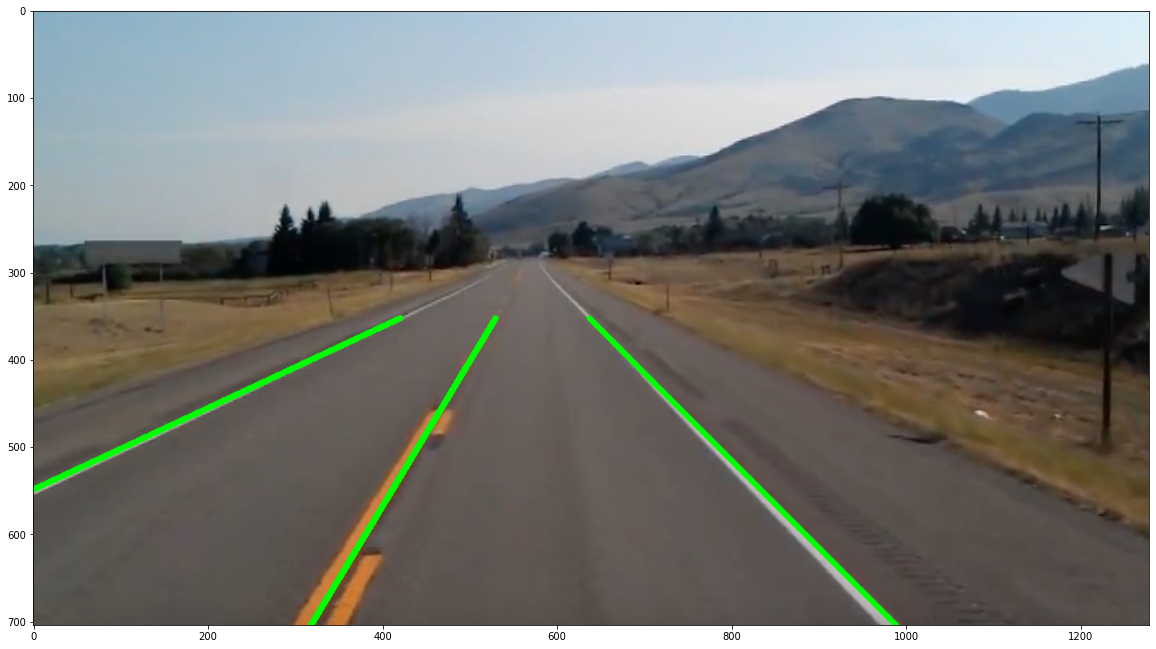

In [10]:
# draw lines
for i in range(len(peaks_indices)):
    # reverse engineer lines from rhos and thetas
    rho = rhos[peaks_indices[i][0]]
    theta = thetas[peaks_indices[i][1]]

    a = abs(np.cos(theta))
    b = abs(np.sin(theta))

    theta_deg = np.rad2deg(theta)
    if 90 < theta_deg < 180:
        a = -a
    elif 180 < theta_deg < 270:
        a = -a
        b = -b
    elif 270 < theta_deg < 360:
        b = -b

    slope = - a / b
    intercept = rho / b

    y1 = output.shape[0]
    y2 = int(y1/2)
    x1 = int((y1 - intercept) / slope)
    x2 = int((y2 - intercept) / slope)

    cv2.line(output, (x1, y1), (x2, y2), (0, 255, 0), 6)

plt.figure(figsize=(20, 20))
plt.imshow(output)